# Street canyon example in Radiosity

This example shows the process of simulating a geometry such as a street canyon while applying different properties to the wall boundaries. The setup of the canyon is comparable to **Sound propagation in street canyons: Comparison between
diffusely and geometrically reflecting boundaries** by Kang published in 2000.

Paper: https://doi.org/10.1121/1.428580


First, import all of our dependencies.

In [1]:
import numpy as np
import pyfar as pf
import sofar as sf
import spharpy as sph
import sparrowpy as sp
import matplotlib.pyplot as plt
import os

%matplotlib inline

Define the street canyon and set general parameters for the simulation.

In [2]:
# canyon boundary dimensions in meters 120 20 18
length = 35  # X
width = 10  # Y
height = 4  # Z  (different heights were used by Kang)

# simulation parameters
patch_size = 4  # small values increase computation time by a lot
etc_duration = 1
etc_time_resolution = 1 / 1000
max_reflection_order = 90
speed_of_sound = 343.2

# create geometry for the two facades and the ground
boundaries = [
    sp.geometry.Polygon(
        np.array(
            [  # corner points
                [0, 0, 0],
                [0, 0, height],
                [length, 0, 0],
                [length, 0, height],
            ],
        ),
        np.array([1, 0, 0]),  # up vector
        np.array([0, 1, 0]),  # normal vector
    ),
    sp.geometry.Polygon(
        np.array(
            [
                [0, 0, 0],
                [0, width, 0],
                [length, 0, 0],
                [length, width, 0],
            ],
        ),
        np.array([1, 0, 0]),
        np.array([0, 0, 1]),
    ),
    sp.geometry.Polygon(
        np.array(
            [
                [0, width, 0],
                [length, width, 0],
                [0, width, height],
                [length, width, height],
            ],
        ),
        np.array([1, 0, 0]),
        np.array([0, -1, 0]),
    ),
]

# for example, set the same position for source and receiver
source = pf.Coordinates(30, 6, 1)
receiver = pf.Coordinates(30, 6, 1)

For further steps create the instance of the simulation class called ``DirectionalRadiosityFast`` from the previously defined boundaries and the patch size.
Two instances are created so that other properties can be compared later.

In [3]:
radiosity_diffuse = sp.DirectionalRadiosityFast.from_polygon(
    boundaries,
    patch_size,
)
radiosity_retroreflection = sp.DirectionalRadiosityFast.from_polygon(
    boundaries,
    patch_size,
)

/home/ubunti/HiWi/sparrowpy/sparrowpy/geometry.py:379: RuntimeWarning: invalid value encountered in divide
  real_size = size/patch_nums


In the diffuse case, the scattering coefficient is set to 1 for each boundary.

In [4]:
# just define a simple point for the BRDF sources and receivers
brdf_sources = pf.Coordinates(0, 0, 1, weights=1)
brdf_receivers = pf.Coordinates(0, 0, 1, weights=1)

# set the coefficient values per frequency band
frequencies = np.array([2000, 4000])
scattering_coefficient = 1  # totally diffuse
scattering_data = pf.FrequencyData(
    [scattering_coefficient, scattering_coefficient],
    frequencies,
)
absorption_coefficient = 0.1
absorption_data = pf.FrequencyData(
    [absorption_coefficient, absorption_coefficient * 2],
    frequencies,
)

# use internal function to construct the BRDF data
brdf_diffuse = sp.brdf.create_from_scattering(
    brdf_sources,
    brdf_receivers,
    scattering_data,
    absorption_data,
)

# set the created scattering data in the radiosity instance
radiosity_diffuse.set_wall_brdf(
    np.arange(len(boundaries)).tolist(),
    brdf_diffuse,
    brdf_sources,
    brdf_receivers,
)

For the retroreflection, BRDF data in the form of a ``.sofa`` file is used.

The BRDF data is visualized below.

SOFA file contained custom entries
----------------------------------
SourceWeights, ReceiverWeights

The BRDF data contains 144 points.


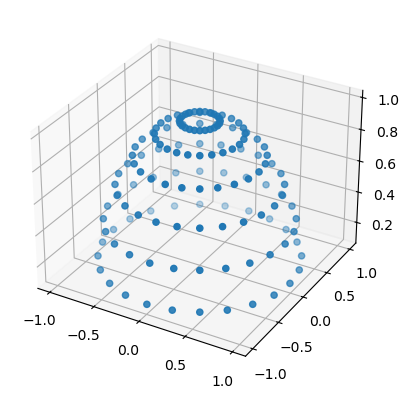

BRDF from source pos: -0.16516830385398643 / 0.6164165017830521 / 0.7699026741943047
BRDF maximum reflective coordinates: 0.45124819792906545 / -0.4512481979290657 / 0.7699026741943047


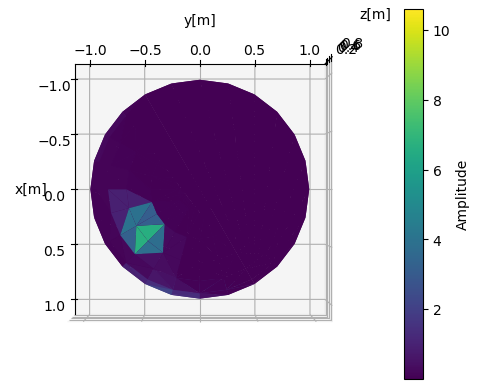

In [ ]:
# use retroreflective scattering for the second simulation
BRDF_path = os.path.join(os.curdir, "brdf_walls_BSC.sofa")
sofa_data = sf.read_sofa(BRDF_path)
brdf_rr, brdf_sources_rr, brdf_receivers_rr = pf.io.convert_sofa(sofa_data)

brdf_sources_rr.weights = sofa_data.SourceWeights
brdf_receivers_rr.weights = sofa_data.ReceiverWeights

radiosity_retroreflection.set_wall_brdf(
    np.arange(len(boundaries)).tolist(),
    brdf_rr,
    brdf_sources_rr,
    brdf_receivers_rr,
)
print("\nThe BRDF data contains", brdf_sources_rr.csize, "points.")

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(
    brdf_receivers_rr.x,
    brdf_receivers_rr.y,
    brdf_receivers_rr.z,
)
plt.show()

direction = 45
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
print(
    "BRDF from source pos:",
    brdf_receivers_rr.x[direction],
    "/",
    brdf_receivers_rr.y[direction],
    "/",
    brdf_receivers_rr.z[direction],
)
ind_max_reflection = np.argmax(brdf_rr.freq[direction, :, -1])
print(
    "BRDF maximum reflective coordinates:",
    brdf_receivers_rr.x[ind_max_reflection],
    "/",
    brdf_receivers_rr.y[ind_max_reflection],
    "/",
    brdf_receivers_rr.z[ind_max_reflection],
)
sph.plot.pcolor_sphere(
    brdf_receivers_rr,
    np.real(brdf_rr.freq[direction, :, -1]),
    ax=ax,
)
ax.view_init(elev=90, azim=0, roll=0)
plt.show()

To run the simulation, the geometry must first be calculated (baked) to enable the computation of energy exchange between patches at a later stage.

The patch to patch relationships contain the form factors, the geometrical relationship between the patches as well as the BRDFs.

This is the most heavy part of the simulation and is independent of the source and receiver positions.

In [ ]:
radiosity_diffuse.bake_geometry()
radiosity_retroreflection.bake_geometry()

/home/ubunti/HiWi/sparrowpy/sparrowpy/classes/RadiosityFast.py:1348: ComplexWarning: Casting complex values to real discards the imaginary part
  form_factors_tilde[i, j, :, :] = form_factors_tilde[


Next, the distribution of the source's initial energy to each visible patch is simulated.

In [ ]:
radiosity_diffuse.init_source_energy(source)
radiosity_retroreflection.init_source_energy(source)

Subsequently, the energy exchange between the patches and the energy at the receiver is calculated.

In [ ]:
radiosity_diffuse.calculate_energy_exchange(
    speed_of_sound=speed_of_sound,
    etc_time_resolution=etc_time_resolution,
    etc_duration=etc_duration,
    max_reflection_order=max_reflection_order,
)
radiosity_retroreflection.calculate_energy_exchange(
    speed_of_sound=speed_of_sound,
    etc_time_resolution=etc_time_resolution,
    etc_duration=etc_duration,
    max_reflection_order=max_reflection_order,
)

Finally, the energy is collected at the specified receiver point(s).

In [ ]:
etc_diffuse = radiosity_diffuse.collect_energy_receiver_mono(
    receivers=receiver,
)
etc_retroreflection = radiosity_retroreflection.collect_energy_receiver_mono(
    receivers=receiver,
)

The two simulations can be visually compared.

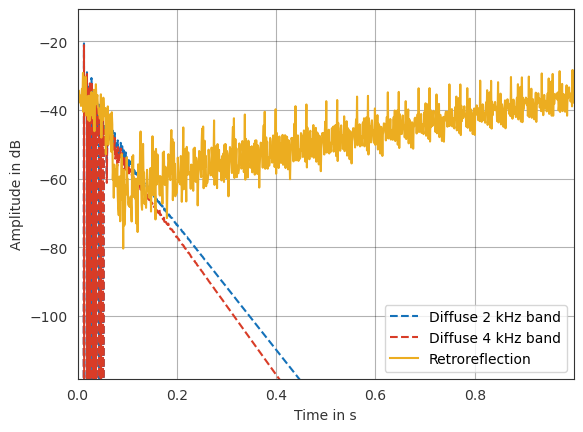

In [ ]:
# plot the results separately for the frequency bands and the scattering types
plt.figure()
pf.plot.time(
    etc_diffuse[0, 0],
    dB=True,
    log_prefix=10,
    label="Diffuse 2 kHz band",
    linestyle="--",
)
pf.plot.time(
    etc_diffuse[0, 1],
    dB=True,
    log_prefix=10,
    label="Diffuse 4 kHz band",
    linestyle="--",
)
pf.plot.time(
    etc_retroreflection[0, -1],  # plot only the highest frequency band (-1)
    dB=True,
    log_prefix=10,
    label="Retroreflection",
)

plt.legend()
plt.show()

In [ ]:
%load_ext watermark
%watermark -v -m -iv

Python implementation: CPython
Python version       : 3.11.14
IPython version      : 9.1.0

Compiler    : GCC 14.3.0
OS          : Linux
Release     : 5.15.167.4-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

sparrowpy : 1.0.0
pyfar     : 0.7.3
numpy     : 1.26.4
matplotlib: 3.10.7
sofar     : 1.2.2

